In [2]:
from statsmodels.stats.power import FTestAnovaPower
import pandas as pd
import pandas as pd
from pyDOE3 import ff2n
import statsmodels.api as sm
from statsmodels.formula.api import ols
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations

For our first experiment, we wan to do a 2^k factorial design to determine which factors are singificant. We can do this by testing the extremes for each factor (ie the absolute max/min values they can take on). This will give us the best idea of their variability across the entire parameter space.

In [3]:
full_design = ff2n(4)

columns = ['Prev.Length', 'Match.Score', 'Tile.Size', 'Prev.Type']

# Convert to DataFrame
design_df = pd.DataFrame(full_design, columns=columns)

# Map coded levels (-1, 1) to meaningful values
design_df['Tile.Size'] = design_df['Tile.Size'].map({-1: 0.1, 1: 0.5})
design_df['Match.Score'] = design_df['Match.Score'].map({-1: 0, 1: 100})
design_df['Prev.Length'] = design_df['Prev.Length'].map({-1: 30, 1: 120})
design_df['Prev.Type'] = design_df['Prev.Type'].map({-1: 'TT', 1: 'AC'})

# Save the design matrix for uploading to the simulator
design_df.to_csv('experiment_1_design.csv', index=False)

# Display the design matrix
print(design_df)

    Prev.Length  Match.Score  Tile.Size Prev.Type
0            30            0        0.1        TT
1            30            0        0.1        AC
2            30            0        0.5        TT
3            30            0        0.5        AC
4            30          100        0.1        TT
5            30          100        0.1        AC
6            30          100        0.5        TT
7            30          100        0.5        AC
8           120            0        0.1        TT
9           120            0        0.1        AC
10          120            0        0.5        TT
11          120            0        0.5        AC
12          120          100        0.1        TT
13          120          100        0.1        AC
14          120          100        0.5        TT
15          120          100        0.5        AC


Since this is a 2^k factorial design, as long as we fit our model in the encoded unit space, we can just use the t-tests output in the model summary to determine which factors are significant. This comes as a result of the orthogonal nature of the encoded unit space for this type of experimental design. As such, we can estimate the required sample size as follows.

In [4]:
from statsmodels.stats.power import TTestIndPower

# Define power analysis parameters
effect_size = 0.4  # Medium effect size
alpha = 0.05       # Significance level
power = 0.8        # Desired power
num_conditions = 16  # 2^4 full factorial

# Compute required sample size per condition
power_analysis = TTestIndPower()
sample_size_per_condition = int(power_analysis.solve_power(effect_size, power=power, alpha=alpha)) + 1  # Round up

# Compute total sample size
total_sample_size = sample_size_per_condition * num_conditions

print(f"Required sample size per condition: {sample_size_per_condition}")
print(f"Total required sample size: {total_sample_size}")

Required sample size per condition: 100
Total required sample size: 1600


Based on this, for an effect size of 0.4, we need 100 units per condition or a total of 1600 units for this test. To air on the side of caution, we can do 250 units per condition for a total of 4000 units in this experiment. 

In [5]:
results_df = pd.read_csv('experiment_1_results.csv')

results_df.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,30,0,0.1,TT,19.611889
1,30,0,0.1,TT,19.047636
2,30,0,0.1,TT,19.926273
3,30,0,0.1,TT,20.674456
4,30,0,0.1,TT,20.483957


We can then map these results back into the encoded unit space to fit our model. The model that we fit is the full model with all interaction terms included. 

In [6]:
model_df = results_df.copy()

model_df['Tile.Size'] = model_df['Tile.Size'].map({0.1: -1, 0.5: 1})
model_df['Match.Score'] = model_df['Match.Score'].map({0: -1, 100: 1})
model_df['Prev.Length'] = model_df['Prev.Length'].map({30: -1, 120: 1})
model_df['Prev.Type'] = model_df['Prev.Type'].map({'TT': -1, 'AC': 1})

column_rename = {'Tile.Size': 'tile_size', 'Match.Score': 'match_score', 'Prev.Length': 'prev_length', 'Prev.Type': 'prev_type', 'Browse.Time': 'browse_time'}

model_df.rename(columns=column_rename, inplace=True)

model1 = ols('browse_time ~ C(tile_size) * C(match_score) * C(prev_length) * C(prev_type)', data=model_df).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     2185.
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:44:13   Log-Likelihood:                -5628.6
No. Observations:                4000   AIC:                         1.129e+04
Df Residuals:                    3984   BIC:                         1.139e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      20.0348      0.063    319.897      0.000      19.912      20.158
C(tile_size)[T.1]                                                              -0.0773      0.089     -0.872      0.383      -0.251       0.096
C(match_score)[T.1]                                                            -3.1372      0.089    -35.420      0.000      -3.311      -2.964
C(prev_length)[T.1]                                                            -0.1781      0.089     -2.010      0.044      -0.352      -0.004
C(prev_type)[T.1]                                                               4.9717      0.089     56.133      0.000       4.798       5.145
C(tile_size)[T.1]:C(match_score)[T.1]                                          -0.0650      0.125     -0.519      0.604      -0.311       0.181
C(tile_size)[T.1]:C(prev_length)[T.1]                                           0.1999      0.125      1.596      0.111      -0.046       0.445
C(match_score)[T.1]:C(prev_length)[T.1]                                         3.2957      0.125     26.312      0.000       3.050       3.541
C(tile_size)[T.1]:C(prev_type)[T.1]                                             0.0731      0.125      0.583      0.560      -0.172       0.319
C(match_score)[T.1]:C(prev_type)[T.1]                                           0.0135      0.125      0.107      0.914      -0.232       0.259
C(prev_length)[T.1]:C(prev_type)[T.1]                                           0.1328      0.125      1.060      0.289      -0.113       0.378
C(tile_size)[T.1]:C(match_score)[T.1]:C(prev_length)[T.1]                      -0.0337      0.177     -0.190      0.849      -0.381       0.314
C(tile_size)[T.1]:C(match_score)[T.1]:C(prev_type)[T.1]                         0.1405      0.177      0.793      0.428      -0.207       0.488
C(tile_size)[T.1]:C(prev_length)[T.1]:C(prev_type)[T.1]                        -0.2572      0.177     -1.452      0.147      -0.604       0.090
C(match_score)[T.1]:C(prev_length)[T.1]:C(prev_type)[T.1]                      -0.3034      0.177     -1.713      0.087      -0.651       0.044
C(tile_size)[T.1]:C(match_score)[T.1]:C(prev_length)[T.1]:C(prev_type)[T.1]     0.1588      0.251      0.634      0.526      -0.332       0.650
==============================================================================
Omnibus:                        2.964   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.765
Skew:                          -0.009   Prob(JB):                        0.251
Kurtosis:                      

Based on the output of this model, we can draw a few preliminary conclusions:
- tile_size is not a significant predictor. It is not included in any significant interactions and does not have a significant main effect.
- match_score is a significant predictor. It has a significant main effect and a significant interaction with prev_length
- prev_length is a significant predictor. It has a significant main effect and a significant interaction with match_score.
- prev_type is a significant predictor. It has a significant main effect but is not involved in any significant interactions.

Because prev_type is not involved in any significant interactions and only has 2 categories, we can conclude that the optimal prev_type is -1 in encoded units which translates to TT in natural units. 

### Experiment 2:

With the conclusions drawn above, we now need to explore only 2 factors. Those are match score and prev_length. To begin to hone in on an optimum for these two variables, we can perform a multi-level factorial experiment for these two predictors. The statistical outcomes we're looking for here will be tested with two group t-tests. 

We can explore 3 levels of each dispersed evenly throughout the parameter space. In combination with the two extremes tested for each parameter above, this will give us a solid initial understanding of the parameter space. 

The levels will be as follows:
- prev_length: 55, 75, 95
- match_score: 25, 50, 75

These 3 levels gives us a total of 9 experimental conditions. Since we will be including the two endpoints for each, this ups the total comparisons to 25. This can be used to estimate a sample size similar to what was done above. 

In [7]:
from statsmodels.stats.power import TTestIndPower

# Define power analysis parameters
effect_size = 0.4  # Medium effect size
alpha = 0.05       # Significance level
power = 0.8        # Desired power
num_conditions = 25 

# Compute required sample size per condition
power_analysis = TTestIndPower()
sample_size_per_condition = int(power_analysis.solve_power(effect_size, power=power, alpha=alpha)) + 1  # Round up

# Compute total sample size
total_sample_size = sample_size_per_condition * num_conditions

print(f"Required sample size per condition: {sample_size_per_condition}")
print(f"Total required sample size: {total_sample_size}")

Required sample size per condition: 100
Total required sample size: 2500


The calcaulations are similar to those done before, so we can again perform the experiment with 250 units per condition. With our 9 total conditions, this will give us 2250 units in this experiment and 6250 units total so far. 

Going forward, we will fix preview type to be TT and tile_size to be 0.2 for the remainder of the experimentation.

In [8]:
results_df2 = pd.read_csv('experiment_2_results.csv')

results_df2.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,55,25,0.2,TT,19.873830
1,55,25,0.2,TT,20.068301
2,55,25,0.2,TT,19.509356
3,55,25,0.2,TT,22.565583
4,55,25,0.2,TT,20.035554


In [9]:
results_df

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,30,0,0.1,TT,19.611889
1,30,0,0.1,TT,19.047636
2,30,0,0.1,TT,19.926273
3,30,0,0.1,TT,20.674456
4,30,0,0.1,TT,20.483957
...,...,...,...,...,...
3995,120,100,0.5,AC,25.389223
3996,120,100,0.5,AC,24.465392
3997,120,100,0.5,AC,23.216393
3998,120,100,0.5,AC,24.420583


In [10]:
relevant_results = results_df.loc[results_df['Prev.Type'] == 'TT']

In [11]:
agg_df = pd.concat([results_df2.copy(), relevant_results])

In [12]:
df_prev_len = agg_df.groupby('Prev.Length')['Browse.Time'].mean().reset_index().rename(columns={'Prev.Length': 'level'})
df_prev_len['factor'] = 'prev_length'

df_match = agg_df.groupby('Match.Score')['Browse.Time'].mean().reset_index().rename(columns={'Match.Score': 'level'})
df_match['factor'] = 'match_score'

df_effect = pd.concat([df_prev_len, df_match])

fig = make_subplots(
    rows=1, cols=2,
    shared_xaxes=False,
    shared_yaxes=True,
    subplot_titles=('prev_length', 'match_score')
)

# Add traces for each factor
factors = ['prev_length', 'match_score']
for i, factor in enumerate(factors, start=1):
    factor_data = df_effect[df_effect['factor'] == factor]
    fig.add_trace(
        go.Scatter(
            x=factor_data['level'],
            y=factor_data['Browse.Time'],
            mode='markers+lines',
            name=factor
        ),
        row=1, col=i
    )

# Update layout
fig.update_layout(
    height=600, width=1000,
    title='Main Effects Plot',
    showlegend=False,
    template='simple_white'
)

for i in range(1, 4):
    fig.update_yaxes(showticklabels=True, row=1, col=i)

fig.update_yaxes(title='Average Session Time')

# Show plot
fig.show()

In [13]:
factor_pairs = list(combinations(['Match.Score', 'Prev.Length'], 2))

fig = make_subplots(
    rows=len(factor_pairs), cols=1,
    subplot_titles=[f'{factor_x} x {factor_y}' for factor_x, factor_y in factor_pairs],
    shared_yaxes=True
)

for col, (factor_x, factor_y) in enumerate(factor_pairs, start=1):
    grouped_data = (
        agg_df.groupby([factor_x, factor_y])['Browse.Time']
        .mean()
        .reset_index()
        .sort_values(by=factor_x) 
    )
    
    for level in grouped_data[factor_y].unique():
        subset = grouped_data[grouped_data[factor_y] == level]
        fig.add_trace(
            go.Scatter(
                x=subset[factor_x],
                y=subset['Browse.Time'],
                mode='lines+markers',
                name=f"{factor_y}: {level}",
            ),
            row=col, col=1
        )

# Update layout
fig.update_layout(
    height=600, width=900,
    title="Two-Factor Interaction Plots",
    template='simple_white',
    showlegend=True
)

# Fix shared y-axis title
fig.update_yaxes(title_text='Average Session Time')

# Show the plot
fig.show()

From these plots, we get a decent idea of where the optimum for each parameter is. For prev_length, it seems to be between 50 and 90. For match_score, it also looks to be between 50 and 90.

We can use these as our -1/+1 conditions for a ccd experiment now.

In [14]:
from pyDOE3 import ccdesign
ccd_design = ccdesign(2, center=(4, 4))

ccd_df = pd.DataFrame(ccd_design, columns=['Prev.Length', 'Match.Score'])

ccd_df['Tile.Size'] = 0.2
ccd_df['Prev.Type'] = 'TT'

def encode_prev(num):
    return (num-70) / 20

def encode_match(num):
    return (num-70) / 20

def decode_prev(num):
    return num*20+70

def decode_match(num):
    return num*20+70

ccd_df['Prev.Length'] = ccd_df['Prev.Length'].apply(decode_prev)
ccd_df['Match.Score'] = ccd_df['Match.Score'].apply(decode_match)

ccd_df.to_csv('experiment_3_design.csv', index=False)

ccd_df

,Prev.Length,Match.Score,Tile.Size,Prev.Type
0,50.000000,50.000000,0.2,TT
1,50.000000,90.000000,0.2,TT
2,90.000000,50.000000,0.2,TT
3,90.000000,90.000000,0.2,TT
4,70.000000,70.000000,0.2,TT
5,70.000000,70.000000,0.2,TT
6,70.000000,70.000000,0.2,TT
7,70.000000,70.000000,0.2,TT
8,41.715729,70.000000,0.2,TT
9,98.284271,70.000000,0.2,TT


For this experiment, we can again do 250 units per condition for safety. This leads to 4000 units for this experiment and a total of 10,250 units so far.

In [15]:
results_df3 = pd.read_csv("experiment_3_results.csv")

# Ensure the correct column names
results_df3.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,50,50,0.2,TT,16.629992
1,50,50,0.2,TT,17.420920
2,50,50,0.2,TT,17.053219
3,50,50,0.2,TT,17.416145
4,50,50,0.2,TT,17.121403


In [16]:
results_df3[(results_df3['Prev.Length'] == 70) & (results_df3['Match.Score'] == 70)]['Browse.Time'].mean()

10.49739903301157

In [17]:
model_df3 = results_df3.copy()

model_df3['Prev.Length'] = model_df3['Prev.Length'].apply(encode_prev)
model_df3['Match.Score'] = model_df3['Match.Score'].apply(encode_match)

column_rename = {'Tile.Size': 'tile_size', 'Match.Score': 'match_score', 'Prev.Length': 'prev_length', 'Prev.Type': 'prev_type', 'Browse.Time': 'browse_time'}

model_df3.rename(columns=column_rename, inplace=True)

model_df3.head()

,prev_length,match_score,tile_size,prev_type,browse_time
0,-1.0,-1.0,0.2,TT,16.629992
1,-1.0,-1.0,0.2,TT,17.420920
2,-1.0,-1.0,0.2,TT,17.053219
3,-1.0,-1.0,0.2,TT,17.416145
4,-1.0,-1.0,0.2,TT,17.121403


In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Create quadratic and interaction terms
model_df3["match_score2"] = model_df3["match_score"] ** 2
model_df3["prev_length2"] = model_df3["prev_length"] ** 2
model_df3["match_score:prev_length"] = model_df3["match_score"] * model_df3["prev_length"]

# Fit the response surface model
model = ols("browse_time ~ match_score + prev_length + match_score2 + prev_length2 + match_score:prev_length", 
            data=model_df3).fit()

# Display model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            browse_time   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     6136.
Date:                Sun, 19 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:52:31   Log-Likelihood:                -5744.3
No. Observations:                4000   AIC:                         1.150e+04
Df Residuals:                    3994   BIC:                         1.154e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  10.4999      0.023    462.042      0.000      10.455      10.544
match_score                -1.0136      0.022    -45.899      0.000      -1.057      -0.970
prev_length                 0.3046      0.022     13.791      0.000       0.261       0.348
match_score2                3.0664      0.021    147.420      0.000       3.026       3.107
prev_length2                1.7512      0.021     84.192      0.000       1.710       1.792
match_score:prev_length     0.9179      0.032     28.511      0.000       0.855       0.981
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.152
Skew:                          -0.006   Prob(JB):                        0.927
Kurtosis:                       2.972   Cond. No.                         2.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

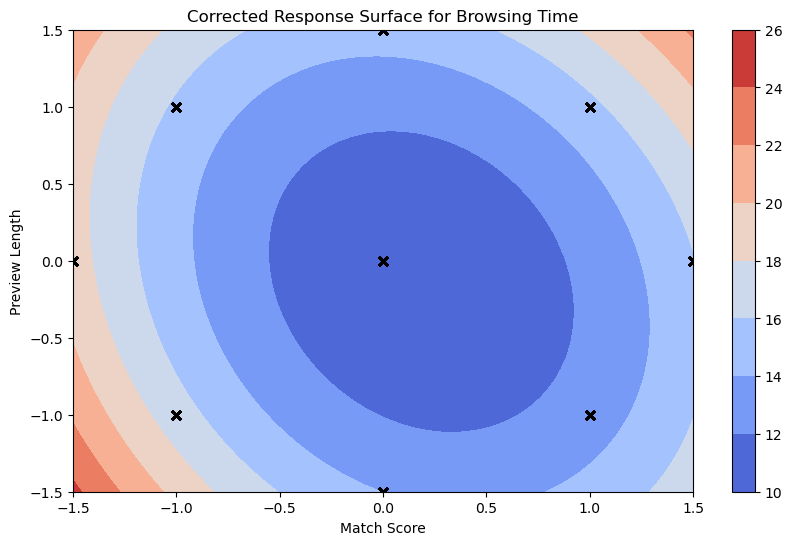

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid of values for Match_Score and Preview_Length
match_score_range = np.linspace(model_df3["match_score"].min(), model_df3["match_score"].max(), 50)
preview_length_range = np.linspace(model_df3["prev_length"].min(), model_df3["prev_length"].max(), 50)
match_grid, preview_grid = np.meshgrid(match_score_range, preview_length_range)

grid_df = pd.DataFrame({
    "match_score": match_grid.ravel(),
    "prev_length": preview_grid.ravel(),
})

grid_df["match_score2"] = grid_df["match_score"] ** 2
grid_df["prev_length2"] = grid_df["prev_length"] ** 2
grid_df["match_score3"] = grid_df["match_score"] ** 3
grid_df["prev_length3"] = grid_df["prev_length"] ** 3
grid_df["match_score:prev_length"] = grid_df["match_score"] * grid_df["prev_length"]


grid_df['predicted_browse_time'] = model.predict(grid_df)

predicted_browsing_time = grid_df["predicted_browse_time"].values.reshape(match_grid.shape)


plt.figure(figsize=(10, 6))
contour = plt.contourf(match_grid, preview_grid, predicted_browsing_time, cmap="coolwarm")
plt.colorbar(contour)
plt.scatter(model_df3["match_score"], model_df3["prev_length"], c="black", marker="x")  # Mark actual data points
plt.xlabel("Match Score")
plt.ylabel("Preview Length")
plt.title("Corrected Response Surface for Browsing Time")
plt.show()

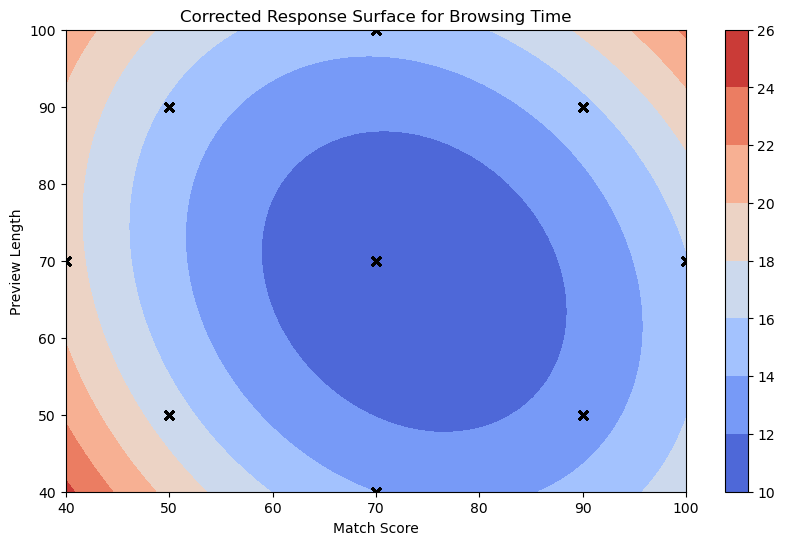

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid of values for Match_Score and Preview_Length
match_score_range = np.linspace(model_df3["match_score"].min(), model_df3["match_score"].max(), 50)
preview_length_range = np.linspace(model_df3["prev_length"].min(), model_df3["prev_length"].max(), 50)
match_grid, preview_grid = np.meshgrid(match_score_range, preview_length_range)

grid_df = pd.DataFrame({
    "match_score": match_grid.ravel(),
    "prev_length": preview_grid.ravel(),
})

grid_df["match_score2"] = grid_df["match_score"] ** 2
grid_df["prev_length2"] = grid_df["prev_length"] ** 2
grid_df["match_score3"] = grid_df["match_score"] ** 3
grid_df["prev_length3"] = grid_df["prev_length"] ** 3
grid_df["match_score:prev_length"] = grid_df["match_score"] * grid_df["prev_length"]


grid_df['predicted_browse_time'] = model.predict(grid_df)

predicted_browsing_time = grid_df["predicted_browse_time"].values.reshape(match_grid.shape)

plt.figure(figsize=(10, 6))
contour = plt.contourf(decode_match(match_grid), decode_prev(preview_grid), predicted_browsing_time, cmap="coolwarm")
plt.colorbar(contour)
plt.scatter(decode_match(model_df3["match_score"]), decode_prev(model_df3["prev_length"]), c="black", marker="x")  # Mark actual data points
plt.xlabel("Match Score")
plt.ylabel("Preview Length")
plt.title("Corrected Response Surface for Browsing Time")
plt.show()

In [49]:
from scipy.optimize import minimize

# Define function to minimize browsing time
def browsing_time_function(x):
    match_score, prev_length = x
    df = pd.DataFrame({"match_score": [match_score], "prev_length": [prev_length]})
    df["match_score2"] = df["match_score"] ** 2
    df["prev_length2"] = df["prev_length"] ** 2
    df["match_score3"] = df["match_score"] ** 3
    df["prev_length3"] = df["prev_length"] ** 3
    df["match_score:prev_length"] = df["match_score"] * df["prev_length"]
    return model.predict(df)[0]  # Return predicted browsing time

# Initial guess for optimization
# x0 = [50, 75]  # Start near the center of the range
x0 = [0.25, -0.25]

# Minimize browsing time
# result = minimize(browsing_time_function, x0, bounds=[(0, 100), (30, 120)])
# result = minimize(browsing_time_function, x0, bounds=[(-1.5, 1.5), (-1.5, 1.5)])

result = minimize(browsing_time_function, x0, bounds=[(-3, 3), (-3, 3)])

# Extract optimal settings
optimal_match_score, optimal_prev_length = result.x

print(f"Optimal Match Score: {optimal_match_score:.2f}")
print(f"Optimal Preview Length: {optimal_prev_length:.2f}")

Optimal Match Score: 0.19
Optimal Preview Length: -0.14


In [50]:
decoded_optimal_match = decode_match(0.19)
decoded_prev_len = decode_prev(-0.14)

print(f"Optimal Match Score: {decoded_optimal_match:.2f}")
print(f"Optimal Preview Length: {decoded_prev_len:.2f}")

Optimal Match Score: 73.80
Optimal Preview Length: 67.20


In [51]:
params = model.params

params

Intercept                  10.499887
match_score                -1.013644
prev_length                 0.304557
match_score2                3.066406
prev_length2                1.751238
match_score:prev_length     0.917854
dtype: float64

In [52]:
b = np.array([params['match_score'], params['prev_length']])

B = np.array([[params['match_score2'], 0.5*params['match_score:prev_length']],
              [0.5*params['match_score:prev_length'], params['prev_length2']]])

In [53]:
xs = -0.5*np.linalg.inv(B)@b

In [54]:
xs

array([ 0.18557427, -0.13558622])

In [55]:
decoded_optimal_match = decode_match(xs[0])
decoded_prev_len = decode_prev(xs[1])

print(f"Optimal Match Score: {decoded_optimal_match:.2f}")
print(f"Optimal Preview Length: {decoded_prev_len:.2f}")

Optimal Match Score: 73.71
Optimal Preview Length: 67.29


In [56]:
df_optimum = pd.DataFrame({'prev_length': [0.18557427], 'match_score': [-0.13558622]})

# Compute polynomial & interaction terms
df_optimum["match_score2"] = df_optimum["match_score"] ** 2
df_optimum["prev_length2"] = df_optimum["prev_length"] ** 2
df_optimum["match_score:prev_length"] = df_optimum["match_score"] * df_optimum["prev_length"]

# Get prediction results
pred_results = model.get_prediction(df_optimum)

# Extract prediction mean and interval
pred_mean = pred_results.predicted_mean[0]
pred_interval = pred_results.conf_int(alpha=0.05)[0]  # 95% prediction interval

# Print results
print(f"Predicted Browsing Time: {pred_mean:.2f}")
print(f"95% Prediction Interval: [{pred_interval[0]:.2f}, {pred_interval[1]:.2f}]")

Predicted Browsing Time: 10.79
95% Prediction Interval: [10.74, 10.83]


In [57]:
df_optimum = pd.DataFrame({'prev_length': [0.19], 'match_score': [-0.14]})

# Compute polynomial & interaction terms
df_optimum["match_score2"] = df_optimum["match_score"] ** 2
df_optimum["prev_length2"] = df_optimum["prev_length"] ** 2
df_optimum["match_score:prev_length"] = df_optimum["match_score"] * df_optimum["prev_length"]

# Get prediction results
pred_results = model.get_prediction(df_optimum)

# Extract prediction mean and interval
pred_mean = pred_results.predicted_mean[0]
pred_interval = pred_results.conf_int(alpha=0.05)[0]  # 95% prediction interval

# Print results
print(f"Predicted Browsing Time: {pred_mean:.2f}")
print(f"95% Prediction Interval: [{pred_interval[0]:.2f}, {pred_interval[1]:.2f}]")

Predicted Browsing Time: 10.80
95% Prediction Interval: [10.75, 10.84]


In [58]:
df_optimum = pd.DataFrame({'prev_length': [encode_prev(70)], 'match_score': [encode_match(70)]})

# Compute polynomial & interaction terms
df_optimum["match_score2"] = df_optimum["match_score"] ** 2
df_optimum["prev_length2"] = df_optimum["prev_length"] ** 2
df_optimum["match_score:prev_length"] = df_optimum["match_score"] * df_optimum["prev_length"]

# Get prediction results
pred_results = model.get_prediction(df_optimum)

# Extract prediction mean and interval
pred_mean = pred_results.predicted_mean[0]
pred_interval = pred_results.conf_int(alpha=0.05)[0]  # 95% prediction interval

# Print results
print(f"Predicted Browsing Time: {pred_mean:.2f}")
print(f"95% Prediction Interval: [{pred_interval[0]:.2f}, {pred_interval[1]:.2f}]")

Predicted Browsing Time: 10.50
95% Prediction Interval: [10.46, 10.54]


## Experiment 4

From above, we can see that rounding to 65 preview length and 75 match score results in a lower predicted browsing time compared to the calculated minimum. This is likely due to some curvature in this area not accounted for by the fitted second order model. To verify the accuracy of this model, we would like to perform a small grid search in the area immediately surrounding the calculated minimum. To do this, we will test preview length of 65 and 70 with match scores of 70,71,72,73,74, and 75. We will then perform a one way anova to examine whether the mean browsing time for these conditions is statistically significant. 

In [31]:
from statsmodels.stats.power import FTestAnovaPower

# Define power analysis parameters
effect_size = 0.4  # Medium effect size (Cohen's f)
alpha = 0.05       # Significance level
power = 0.8        # Desired statistical power
num_groups = 12      # Match Score levels (71, 72, 73, 74, 75) for each Preview Length level (65, 70)

# Initialize power analysis
power_analysis = FTestAnovaPower()

# Solve for the required sample size per group
sample_size_per_condition = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, k_groups=num_groups)

# Round up to ensure adequate sampling
sample_size_per_condition = int(sample_size_per_condition) + 1

# Compute total required sample size
total_sample_size = sample_size_per_condition * num_groups

print(f"Required sample size per condition: {sample_size_per_condition}")
print(f"Total required sample size: {total_sample_size}")


Required sample size per condition: 116
Total required sample size: 1392


The calculated sample size required for this experiment is 107.To again err on the side of caution, we will continue with the 250 units per condition that has been done previously. With the 12 conditions, this experiment will require 3000 units, leading to 13250 units total thus far.

In [32]:
results_df4 = pd.read_csv('experiment_4_results.csv')

results_df4.head()

,Prev.Length,Match.Score,Tile.Size,Prev.Type,Browse.Time
0,65,70,0.2,TT,12.119693
1,65,70,0.2,TT,10.539271
2,65,70,0.2,TT,11.638886
3,65,70,0.2,TT,10.572214
4,65,70,0.2,TT,11.246331


In [33]:
model_df4 = results_df4.copy()

column_rename = {'Tile.Size': 'tile_size', 'Match.Score': 'match_score', 'Prev.Length': 'prev_length', 'Prev.Type': 'prev_type', 'Browse.Time': 'browse_time'}

model_df4.rename(columns=column_rename, inplace=True)

model_df4.head()

,prev_length,match_score,tile_size,prev_type,browse_time
0,65,70,0.2,TT,12.119693
1,65,70,0.2,TT,10.539271
2,65,70,0.2,TT,11.638886
3,65,70,0.2,TT,10.572214
4,65,70,0.2,TT,11.246331


In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit a two-way ANOVA model
model = ols("browse_time ~ C(match_score) + C(prev_length)", data=model_df4).fit()

# Perform ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table

# Display results
anova_table

,sum_sq,df,F,PR(>F)
C(match_score),12.394267,5.0,2.382003,3.629319e-02
C(prev_length),55.611480,1.0,53.438707,3.406855e-13
Residual,3114.692854,2993.0,NaN,NaN


Based on the above ANOVA table, we can see that among these levels, both match_score and preview length are significant predictors. This indicates that there is a difference in browsing time among these levels. To find out specifically which combination is the best, we will perform a series of pair-wise t tests using the Bonferroni correction to account for the multiple comparison problem.

In [39]:
# Get mean browsing times for each (match_score, preview_length) condition
mean_browsing_times = model_df4.groupby(["match_score", "prev_length"])["browse_time"].mean()

# Find the group with the lowest mean browsing time
best_group = mean_browsing_times.idxmin()
best_time = mean_browsing_times.min()

print(f"Best Group (Match Score, Preview Length): {best_group}")
print(f"Lowest Mean Browsing Time: {best_time:.2f}")

mean_browsing_times.reset_index().sort_values(by='browse_time', ascending=True)

Best Group (Match Score, Preview Length): (73, 70)
Lowest Mean Browsing Time: 10.47


,match_score,prev_length,browse_time
7,73,70,10.470470
9,74,70,10.522594
5,72,70,10.528081
11,75,70,10.529745
3,71,70,10.562588
1,70,70,10.587602
4,72,65,10.620938
6,73,65,10.751702
2,71,65,10.790628
8,74,65,10.828865


From the experimental data, we can see that the best group is 74 match score, 70 preview length. Now we would like to perform a series of pairwise t tests to determine if this is statstically significant.

In [43]:
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Extract the best group's browsing time data
best_group_data = model_df4[(model_df4["match_score"] == 73) & (model_df4["prev_length"] == 70)]["browse_time"]

# Get all unique (match_score, preview_length) combinations except the best group
other_groups = model_df4[~((model_df4["match_score"] == 73) & (model_df4["prev_length"] == 70))]["condition"].unique()

# Store p-values and comparisons
p_values = []
comparisons = []

# Perform pairwise t-tests comparing the best group to all other groups
for group in other_groups:
    group_match_score, group_preview_length = map(int, group.split("_"))
    other_group_data = model_df4[(model_df4["match_score"] == group_match_score) & (model_df4["prev_length"] == group_preview_length)]["browse_time"]
    
    # Perform Welch's t-test (for unequal variances)
    t_stat, p_value = ttest_ind(best_group_data, other_group_data, equal_var=False, alternative="less")  # One-tailed test (best group < others)
    
    p_values.append(p_value)
    comparisons.append((f"{best_group_data.name}", group))

# Apply Bonferroni correction for multiple comparisons
_, p_values_corrected, _, _ = multipletests(p_values, alpha=0.05, method="bonferroni")

# Store results in a DataFrame
results_df = pd.DataFrame(comparisons, columns=["Best Group", "Compared Group"])
results_df["Raw P-Value"] = p_values
results_df["Bonferroni Corrected P-Value"] = p_values_corrected
results_df["Significant Difference (p < 0.05)"] = p_values_corrected < 0.05


results_df

,Best Group,Compared Group,Raw P-Value,Bonferroni Corrected P-Value,Significant Difference (p < 0.05)
0,browse_time,70_65,1.149052e-07,0.000001,True
1,browse_time,71_65,2.501079e-04,0.002751,True
2,browse_time,72_65,4.863419e-02,0.534976,False
3,browse_time,73_65,1.515704e-03,0.016673,True
4,browse_time,74_65,5.484444e-05,0.000603,True
5,browse_time,75_65,5.850518e-06,0.000064,True
6,browse_time,70_70,9.561744e-02,1.000000,False
7,browse_time,71_70,1.596902e-01,1.000000,False
8,browse_time,72_70,2.696244e-01,1.000000,False
9,browse_time,74_70,2.896031e-01,1.000000,False


From the output, we can see that for any preview_length of 70, the difference is not statistically singnificant. This is also true for 72 match score and 65 preview length. Therefore, we can conclude that the optimal preview length is 70 and the associated match score does not matter as long as it is between 70 and 75. Because of this, we will choose a match score of 70 and a preview length of 70 as well. From previous experimentation, the model fits this area well, with a mean observed browse time of 10.497 seconds and a predicted browse time of 10.5 seconds from the model fitted in experiment 3. 